In [1]:
# Load in relevant libraries, and alias where appropriate
import torch
import torch.nn as nn
import torch.nn.functional  as F

import torchvision
import torchvision.transforms as transforms
from torchinfo import summary

import numpy as np
import matplotlib.pyplot as plt

# Define relevant variables for the Machine Learning task
batch_size = 64
num_classes = 10
learning_rate = 0.001
num_epochs = 10

# Device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("using device: %s" % device)

using device: cuda


In [2]:
#Loading the dataset and preprocessing
# Note: the MNIST data can't be used as it is for the LeNet5 architecture.
# The LeNet5 architecture accepts the input to be 32x32 and the MNIST images are 28x28.
train_dataset = torchvision.datasets.MNIST(root = './data',
                                           train = True,
                                           transform = transforms.Compose([
                                                  transforms.Resize((32,32)),
                                                  transforms.ToTensor(),
                                                  transforms.Normalize(mean = (0.1307,), std = (0.3081,))]),
                                           download = True)

test_dataset = torchvision.datasets.MNIST(root = './data',
                                          train = False,
                                          transform = transforms.Compose([
                                                  transforms.Resize((32,32)),
                                                  transforms.ToTensor(),
                                                  transforms.Normalize(mean = (0.1325,), std = (0.3105,))]),
                                          download=True)

# Data loaders allow us to iterate through the data in batches,
# and the data is loaded while iterating and not at once in start.
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = batch_size,
                                          shuffle = True)

class_names = train_dataset.classes

print(train_dataset)
print(test_dataset)

print(train_dataset[0][0].shape)
print(class_names)

# img, label = train_dataset[0]
# plt.imshow(img.numpy()[0], cmap='gray')
# plt.title(f"{class_names[label]}")

print("number of batches that we have now with the current batch-size:", len(train_loader), len(test_loader))

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               Resize(size=(32, 32), interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.1325,), std=(0.3105,))
           )
torch.Size([1, 32, 32])
['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
number of batches that we have now with the current batch-size: 938 157


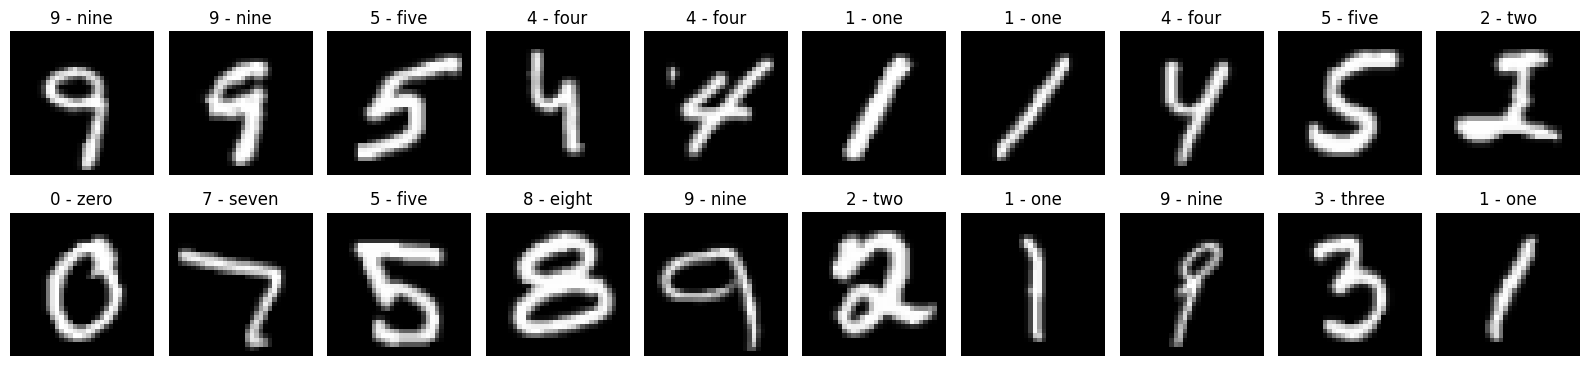

In [3]:
# MNIST dataset samples
torch.manual_seed(0)

fig = plt.figure(figsize=(16, 4))
rows, cols = 2, 10

for i in range(1, (rows*cols) + 1):
    rand_ind = torch.randint(0, len(train_dataset), size=[1]).item()
    img, label = train_dataset[rand_ind]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.numpy()[0], cmap='gray')
    plt.title(f"{class_names[label]}")
    plt.axis(False)
    plt.tight_layout()

In [4]:
# '''
# # Define the convolutional neural network
# class LeNet5_v0(nn.Module):
#     def __init__(self):
#         super(LeNet5_v0, self).__init__()
#         # 1 input image channel, 6 output channels, 5x5 square convolution
#         # kernel
#         self.conv1 = nn.Sequential(
#             nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0),
#             nn.BatchNorm2d(6),
#             nn.ReLU(),
#             # Max pooling over a (2, 2) window
#             nn.MaxPool2d(kernel_size=2, stride=2))
#         self.conv2 = nn.Sequential(
#             nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
#             nn.BatchNorm2d(16),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2))
#         # flatten all dimensions except the batch dimension
#         self.flat1 = nn.Flatten()
#         # an affine operation: y = Wx + b
#         self.fc1 = nn.Linear(16 * 5 * 5, 120)    # 5*5 from image dimension
#         self.relu1 = nn.ReLU()
#         self.fc2 = nn.Linear(120, 84)
#         self.relu2 = nn.ReLU()
#         self.fc3 = nn.Linear(84, 10)

#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.conv2(x)
#         x = self.flat1(x)
#         x = self.fc1(x)
#         x = self.relu1(x)
#         x = self.fc2(x)
#         x = self.relu2(x)
#         x = self.fc3(x)
#         return x

# model_v0 = LeNet5_v0()
# print(model_v0)
# summary(model=model_v0, input_size=(1, 1, 32, 32), col_width=20, 
#         col_names=['input_size', 'output_size', 'num_params', 'trainable'], 
#         row_settings=['var_names'], verbose=0)
# '''

In [5]:
# Define the convolutional neural network
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # 5*5 from image dimension
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), kernel_size=(2, 2), stride=2)
        # If the size is a square, you can specify with a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), kernel_size=2, stride=2)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = LeNet5()
# print(model)
summary(model=model, input_size=(1, 1, 32, 32), col_width=20, 
        col_names=['input_size', 'output_size', 'num_params', 'trainable'], 
        row_settings=['var_names'], verbose=0)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
LeNet5 (LeNet5)                          [1, 1, 32, 32]       [1, 10]              --                   True
├─Conv2d (conv1)                         [1, 1, 32, 32]       [1, 6, 28, 28]       156                  True
├─Conv2d (conv2)                         [1, 6, 14, 14]       [1, 16, 10, 10]      2,416                True
├─Linear (fc1)                           [1, 400]             [1, 120]             48,120               True
├─Linear (fc2)                           [1, 120]             [1, 84]              10,164               True
├─Linear (fc3)                           [1, 84]              [1, 10]              850                  True
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
Total mult-adds (M): 0.42
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.25
Estimated Total Size (MB): 0.30

In [6]:
model = model.to(device)

#Setting the loss function
cost = nn.CrossEntropyLoss()

#Setting the optimizer with the model parameters and learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#this is defined to print how many steps are remaining when training
total_step = len(train_loader)

for epoch in range(num_epochs):
    model.train()   # sets the module in training mode
    for i, (images, labels) in enumerate(train_loader):  
        images = images.to(device)
        labels = labels.to(device)
        
        #Forward pass
        outputs = model(images)
        loss = cost(outputs, labels)
        	
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        		
        if (i+1) % 400 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
        		           .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

Epoch [1/10], Step [400/938], Loss: 0.1691
Epoch [1/10], Step [800/938], Loss: 0.0430
Epoch [2/10], Step [400/938], Loss: 0.0360
Epoch [2/10], Step [800/938], Loss: 0.0178
Epoch [3/10], Step [400/938], Loss: 0.0779
Epoch [3/10], Step [800/938], Loss: 0.1330
Epoch [4/10], Step [400/938], Loss: 0.0255
Epoch [4/10], Step [800/938], Loss: 0.0164
Epoch [5/10], Step [400/938], Loss: 0.0071
Epoch [5/10], Step [800/938], Loss: 0.0117
Epoch [6/10], Step [400/938], Loss: 0.0108
Epoch [6/10], Step [800/938], Loss: 0.0719
Epoch [7/10], Step [400/938], Loss: 0.0026
Epoch [7/10], Step [800/938], Loss: 0.0007
Epoch [8/10], Step [400/938], Loss: 0.0592
Epoch [8/10], Step [800/938], Loss: 0.0024
Epoch [9/10], Step [400/938], Loss: 0.0012
Epoch [9/10], Step [800/938], Loss: 0.0015
Epoch [10/10], Step [400/938], Loss: 0.0717
Epoch [10/10], Step [800/938], Loss: 0.0552


In [7]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
model.eval()    # sets the module in evaluation mode
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))

Accuracy of the network on the 10000 test images: 99.02 %


In [8]:
# EXPORTING A MODEL FROM PYTORCH TO ONNX
model = model.to('cpu')
model.eval()
x = torch.randn(size=(1, 1, 32, 32), dtype=torch.float32, requires_grad=True)
torch.onnx.export(model,                                        # model being run
                  x,                                            # model input (or a tuple for multiple inputs)
                  "LeNet5.onnx",                                # where to save the model (can be a file or file-like object)
                  export_params=True,                           # store the trained parameter weights inside the model file
                  opset_version=11,                             # the ONNX version to export the model to
                  do_constant_folding=True,                     # whether to execute constant folding for optimization
                  input_names = ['input'],                      # the model's input names
                  output_names = ['output'],                    # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},   # variable length axes
                                'output' : {0 : 'batch_size'}})

torch_out = model(x)
print(torch_out)

tensor([[-1.5929,  0.0963, -0.3935,  0.9276, -1.7349,  0.4934, -1.2676, -0.4512,
          0.2838, -2.1801]], grad_fn=<AddmmBackward>)


In [9]:
# run the model with ONNX Runtime
import onnx

onnx_model = onnx.load("LeNet5.onnx")
onnx.checker.check_model(onnx_model)
print(onnx.helper.printable_graph(onnx_model.graph))

graph torch-jit-export (
  %input[FLOAT, batch_sizex1x32x32]
) initializers (
  %conv1.bias[FLOAT, 6]
  %conv1.weight[FLOAT, 6x1x5x5]
  %conv2.bias[FLOAT, 16]
  %conv2.weight[FLOAT, 16x6x5x5]
  %fc1.bias[FLOAT, 120]
  %fc1.weight[FLOAT, 120x400]
  %fc2.bias[FLOAT, 84]
  %fc2.weight[FLOAT, 84x120]
  %fc3.bias[FLOAT, 10]
  %fc3.weight[FLOAT, 10x84]
) {
  %11 = Conv[dilations = [1, 1], group = 1, kernel_shape = [5, 5], pads = [0, 0, 0, 0], strides = [1, 1]](%input, %conv1.weight, %conv1.bias)
  %12 = Relu(%11)
  %13 = MaxPool[ceil_mode = 0, kernel_shape = [2, 2], pads = [0, 0, 0, 0], strides = [2, 2]](%12)
  %14 = Conv[dilations = [1, 1], group = 1, kernel_shape = [5, 5], pads = [0, 0, 0, 0], strides = [1, 1]](%13, %conv2.weight, %conv2.bias)
  %15 = Relu(%14)
  %16 = MaxPool[ceil_mode = 0, kernel_shape = [2, 2], pads = [0, 0, 0, 0], strides = [2, 2]](%15)
  %17 = Flatten[axis = 1](%16)
  %18 = Gemm[alpha = 1, beta = 1, transB = 1](%17, %fc1.weight, %fc1.bias)
  %19 = Relu(%18)
  %20 = Ge

In [10]:
import onnxruntime

# Create an inference session
ort_session = onnxruntime.InferenceSession("LeNet5.onnx", providers=["CPUExecutionProvider"])

# Convert tensor to ndarray
def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()
    
# Construct the dictionary of input and compute ONNX Runtime output prediction
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(x)}
ort_outs = ort_session.run(None, ort_inputs)

# compare ONNX Runtime and PyTorch results
np.testing.assert_allclose(to_numpy(torch_out), ort_outs[0], rtol=1e-03, atol=1e-05)

# print(ort_outs[0])
# print(to_numpy(torch_out))
print("Exported model has been tested with ONNXRuntime, and the result looks good!")

Exported model has been tested with ONNXRuntime, and the result looks good!


torch.Size([1, 1, 32, 32])
Predicted result: 9
[[ -7.3942366   -3.594074    -6.888728    -3.2551394   -0.40210578
   -4.4037     -11.429418     1.6124191   -4.20996      9.407155  ]]
torch.Size([1, 1, 32, 32])
Predicted result: 6
[[ -0.6023639  -14.128446   -13.355487   -14.462329     1.0749719
    0.03415342  21.28168    -19.510466    -9.050362    -6.4096947 ]]


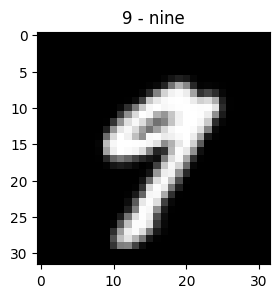

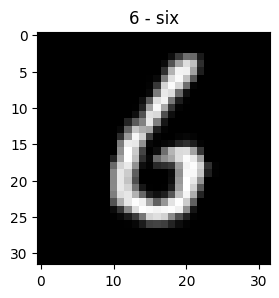

In [11]:
# Comparison of actual labels and predicted results
img_1, label_1 = test_dataset[20]
plt.figure(figsize=(3, 4))
plt.imshow(img_1.numpy()[0], cmap='gray')
plt.title(f"{class_names[label_1]}")

img_1.unsqueeze_(0)
print(img_1.shape)

ort_inputs_demo = {ort_session.get_inputs()[0].name: to_numpy(img_1)}
ort_outs_demo = ort_session.run(None, ort_inputs_demo)
img_out_y = ort_outs_demo[0]
print("Predicted result:", img_out_y.argmax())
print(img_out_y)

img_2, label_2 = test_dataset[50]
plt.figure(figsize=(3, 4))
plt.imshow(img_2.numpy()[0], cmap='gray')
plt.title(f"{class_names[label_2]}")

img_2.unsqueeze_(0)
print(img_2.shape)

ort_inputs_demo = {ort_session.get_inputs()[0].name: to_numpy(img_2)}
ort_outs_demo = ort_session.run(None, ort_inputs_demo)
img_out_y = ort_outs_demo[0]
print("Predicted result:", img_out_y.argmax())
print(img_out_y)

np.savetxt("input_data_lenet5.txt", np.append(img_1.flatten(), img_2.flatten()))